### Data Loading

In [229]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, explode, size, expr, array_distinct, when, regexp_extract, coalesce, lit, row_number, to_date, year, desc
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
from ast import literal_eval
from collections import Counter
import seaborn as sns
from scipy.stats import ttest_ind, pointbiserialr, spearmanr


spark = SparkSession.builder.getOrCreate()

In [ ]:
profiles = spark.read.parquet('/linkedin/people')
df_8000 = pd.read_csv("data/8000_scraped_data.csv")
df_9000 = pd.read_csv("data/9000_scraped_data.csv")
df_250000 = pd.read_csv("data/initial_scraped_data.csv")

df_8000 = df_8000[df_8000['error'].isna()][["id", "url", "followers", "connections", "is_influencer"]]
df_9000 = df_9000[df_9000['error'].isna()][["id", "url", "followers", "connections", "is_influencer"]]
df_250000 = df_250000[["id", "url", "followers", "connections", "is_influencer"]]
df_8000 = df_8000[df_8000['is_influencer'].isin([0, 1, "0", "1"])]
df_9000 = df_9000[df_9000['is_influencer'].isin([0, 1, "0", "1"])]
df_250000 = df_250000[df_250000['is_influencer'].isin([0, 1, "0", "1"])]

scraped_df = pd.concat([df_8000, df_9000, df_250000])
scraped_df['is_influencer'] = scraped_df['is_influencer'].astype('int')
scraped_df['nan_count'] = scraped_df.isna().sum(axis=1)
scraped_df = scraped_df.sort_values('nan_count').drop('nan_count', axis=1).drop_duplicates(subset=["id"]).drop_duplicates(subset=["url"])

scraped_profiles_ids = scraped_df['id'].tolist()
scraped_profiles_urls = scraped_df['url'].tolist()
ids_df = spark.createDataFrame([(id,) for id in scraped_profiles_ids], ['id'])
urls_df = spark.createDataFrame([(url,) for url in scraped_profiles_urls], ['url'])
filtered_profiles_df = profiles.join(ids_df, profiles['id'] == ids_df['id'], 'left_semi').union(profiles.join(urls_df, profiles['url'] == urls_df['url'], 'left_semi')).distinct()

scraped_df['is_influencer'] = scraped_df['is_influencer'].astype('str')
scraped_df['followers'] = scraped_df['followers'].astype('str')
scraped_df['connections'] = scraped_df['connections'].astype('str')
spark_scraped_df = spark.createDataFrame(scraped_df)

joined_df = spark_scraped_df.alias('s').join(
    filtered_profiles_df.alias('f'),
    (lower(col('s.id')) == lower(col('f.id'))) | (col('s.url') == col('f.url')),
    how='inner')
    
final_df = joined_df.select(
    col('f.id').alias('id'), col('f.url').alias('url'),
    coalesce(col('s.followers'), col('f.followers')).alias('followers'),
    'connections',
    'is_influencer',
     *[col(c).alias(c) for c in filtered_profiles_df.columns if c not in ['id', 'url', 'followers']]
).drop('f.followers')

final_df = final_df.select('id', 'url', 'about', 'connections', 'is_influencer','certifications', 'city', 'current_company', 'current_company:company_id', 'current_company:name','education', 'educations_details', 'experience', 'followers',
'following', 'groups' , 'languages', 'people_also_viewed','position', 'posts', 'recommendations', 'recommendations_count', 'volunteer_experience', 'сourses')

missing_row_df = profiles.filter(col('id') == 'Laysha-ward-520159150').withColumn('is_influencer', lit("1")).withColumn('connections', lit("500"))
missing_row_df = missing_row_df.select('id', 'url', 'about', 'connections', 'is_influencer','certifications', 'city', 'current_company', 'current_company:company_id', 'current_company:name','education', 'educations_details', 'experience', 'followers',
'following', 'groups' , 'languages', 'people_also_viewed','position', 'posts', 'recommendations', 'recommendations_count', 'volunteer_experience', 'сourses')
final_df = final_df.union(missing_row_df)


/databricks/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,243,245,246) have mixed types.Specify dty

### Data Processing & EDA

#### Missing Data

In [230]:
all_df = pd.read_csv("ds_lab_data_final.csv")
# Manully filling missing influencers data 
all_df.loc[all_df['id'] == 'beatriz-acevedo-25848063', 'followers'] = 20077
all_df.loc[all_df['id'] == 'gordonramsayofficial', 'connections'] = 500
all_df.loc[all_df['id'] == 'stevenash10', 'followers'] = 11277
all_df.loc[all_df['id'] == 'blaketoliver', 'followers'] = 17339
all_df.loc[all_df['id'] == 'mortimerjbuckley', 'followers'] = 37500
all_df.loc[all_df['id'] == 'brian-doubles-24a6857', 'followers'] = 9787
all_df.loc[all_df['id'] == 'amirarashad', 'followers'] = 9833
all_df.loc[all_df['id'] == 'itsaldea', 'followers'] = 26201
all_df.loc[all_df['id'] == 'ray-givler-62542a23', 'followers'] = 11709
all_df.loc[all_df['id'] == 'blake-michael-a460901a6', 'followers'] = 6146
all_df.loc[all_df['id'] == 'alejandroromeropaniagua', 'followers'] = 8916
all_df.loc[all_df['id'] == 'chuck-robbins', 'followers'] = 102721
all_df.loc[all_df['id'] == 'mark-smucker', 'followers'] = 10131
all_df.loc[all_df['id'] == 'charleneli', 'followers'] = 271054
all_df.loc[all_df['id'] == 'ethan-evans-4461b', 'followers'] = 98874
all_df.loc[all_df['id'] == 'daisyaugerdominguez', 'followers'] = 28370
all_df.loc[all_df['id'] == 'mattville', 'followers'] = 19547
all_df.loc[all_df['id'] == 'followalisont', 'followers'] = 48992

# Type conversion from string to the actual type 
import ast
def parse_complex_column(text):
    try:
        return ast.literal_eval(text)
    except (SyntaxError, ValueError):
        return None

all_df['certifications'] = all_df['certifications'].apply(parse_complex_column)
all_df['current_company'] = all_df['current_company'].apply(parse_complex_column)
all_df['groups'] = all_df['groups'].apply(parse_complex_column)
all_df['people_also_viewed'] = all_df['people_also_viewed'].apply(parse_complex_column)
all_df['volunteer_experience'] = all_df['volunteer_experience'].apply(parse_complex_column)
all_df['сourses'] = all_df['сourses'].apply(parse_complex_column)
all_df['education'] = all_df['education'].apply(parse_complex_column)
all_df['experience'] = all_df['experience'].apply(parse_complex_column)
all_df['posts'] = all_df['posts'].apply(parse_complex_column)
all_df['educations_details'] = all_df['educations_details'].apply(parse_complex_column)
all_df['languages'] = all_df['languages'].apply(parse_complex_column)

groups                        100.000000
educations_details             99.996628
posts                          97.183521
сourses                        96.542152
volunteer_experience           91.328406
recommendations_count          90.812164
languages                      89.884951
certifications                 88.414522
about                          74.522813
current_company:company_id     57.664398
education                      51.736979
current_company:name           33.896280
people_also_viewed             33.437731
experience                     27.149542
followers                      18.798257
position                        4.061380
current_company                 3.097453
connections                     0.694941
url                             0.000000
city                            0.000000
recommendations                 0.000000
is_influencer                   0.000000
id                              0.000000
dtype: float64


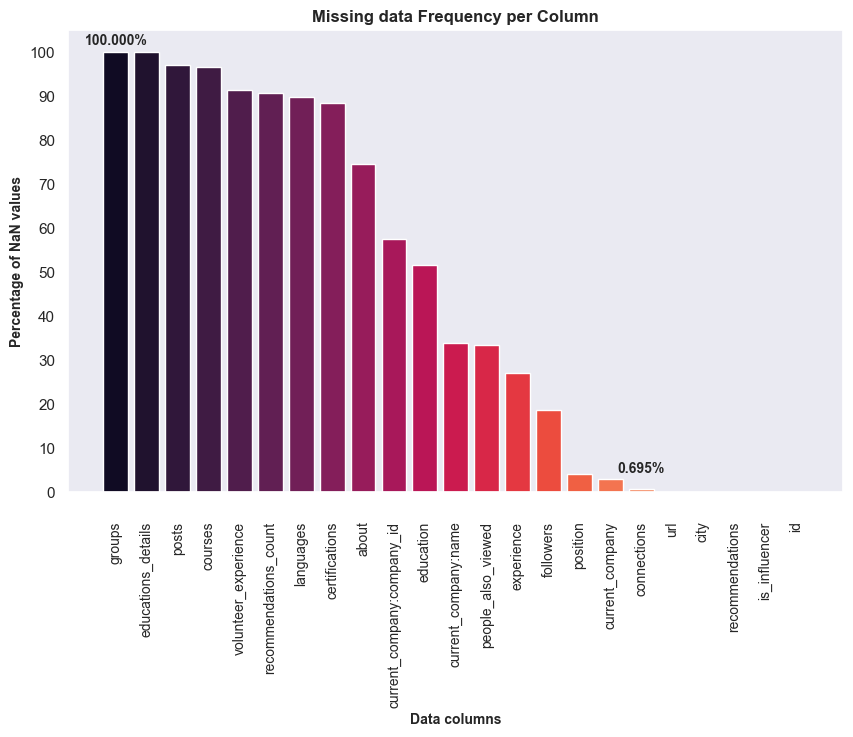

In [109]:
# Analyze missing values
null_values = [None, np.nan, [], {}, '']
nan_counts = (all_df.isin(null_values) | all_df.isna()).sum().sort_values(ascending=False)
nan_counts = nan_counts[nan_counts.index != 'following']
nan_perc = nan_counts / len(all_df) * 100
print(nan_perc)
colors = sns.color_palette("rocket", len(nan_counts))

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(nan_counts.index, nan_perc.values, color=colors)
ax.set_xticks(range(len(nan_counts)))
ax.set_xticklabels(nan_counts.index, rotation=90, ha='center', fontsize=10)
ax.tick_params(axis='x', which='major', pad=15)
ax.set_ylabel('Percentage of NaN values', fontweight = "bold")
ax.set_xlabel('Data columns', fontweight = "bold")
ax.set_title('Missing data Frequency per Column', fontweight = "bold")
y_ticks = np.arange(0, 101, 10)
ax.set_yticks(y_ticks)
plt.grid(False)

non_zero_perc = nan_perc[nan_perc > 0]
if len(non_zero_perc) > 0:
    max_idx = non_zero_perc.idxmax()
    min_idx = non_zero_perc.idxmin()
    ax.text(max_idx, non_zero_perc[max_idx]+1, f'{non_zero_perc[max_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')
    ax.text(min_idx, non_zero_perc[min_idx]+3, f'{non_zero_perc[min_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

In [231]:
# Removing columns with almost 100% missing values + removing following columns (almost identical to followers column)
df = all_df.drop(['groups', 'following', 'educations_details'], axis=1)
df = df.dropna(subset=['connections', 'followers'])
df['connections'] = df['connections'].astype(int).astype(str)

# Fixing data issue- connection values are sometimes concated to itself. For example 4242 should be 42.
df['connections'] = df['connections'].apply(lambda x: x[:len(x)//2] if x[:len(x)//2] == x[len(x)//2:] else x)
df['connections'] = pd.to_numeric(df['connections'], errors='coerce') # convert to numeric

#### Label Analysis- Distribution & Features correlations

In [111]:
label_value_counts = df['is_influencer'].value_counts()
label_percentages = (label_value_counts / len(df)) * 100
label_dist_df = pd.DataFrame({'Value': label_value_counts.index, 
                          'Count': label_value_counts.values, 
                          'Percentage': label_percentages.values})
label_dist_df = label_dist_df.sort_values(by='Value')
label_dist_df.index = ["Non-Influencers", "Influencers"]
label_dist_df['Percentage'] = label_dist_df['Percentage'].round(3)
label_dist_df

,Value,Count,Percentage
Non-Influencers,0,215385,99.978
Influencers,1,47,0.022


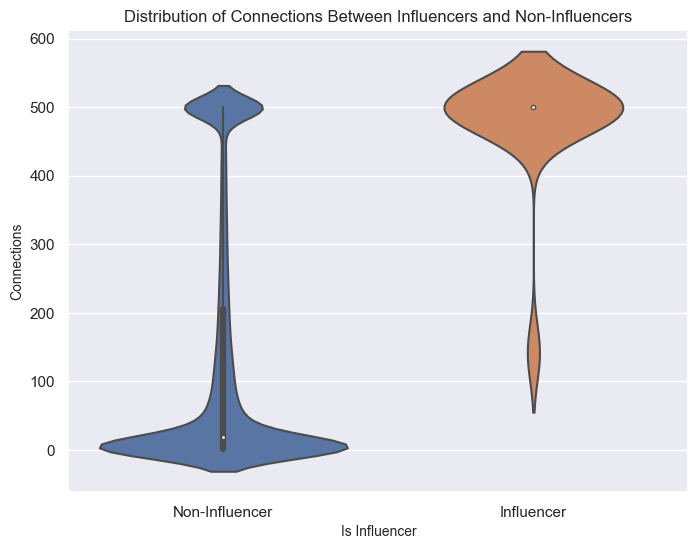

In [112]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='is_influencer', y='connections', data=df)
plt.xlabel('Is Influencer')
plt.ylabel('Connections')
plt.title('Distribution of Connections Between Influencers and Non-Influencers')
plt.xticks(ticks=[0, 1], labels=['Non-Influencer', 'Influencer'])
plt.show()

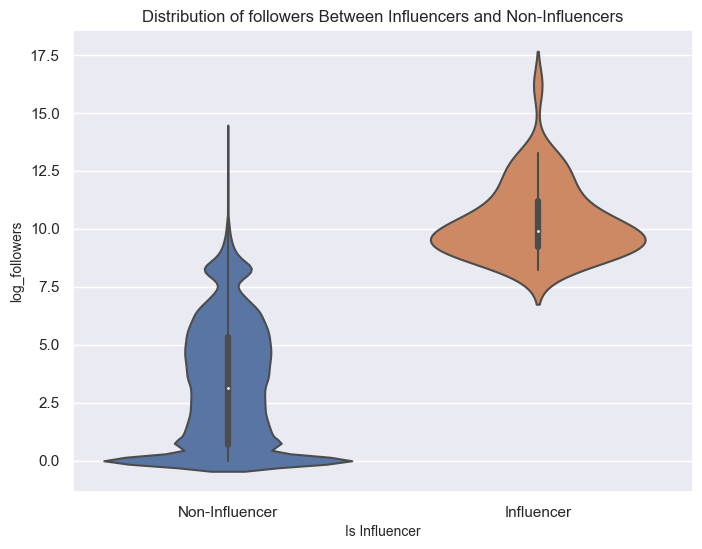

In [113]:
plt.figure(figsize=(8, 6))
df['log_followers'] = np.log(df['followers'])
sns.violinplot(x='is_influencer', y='log_followers', data=df)
plt.xlabel('Is Influencer')
plt.ylabel('log_followers')
plt.title('Distribution of followers Between Influencers and Non-Influencers')
plt.xticks(ticks=[0, 1], labels=['Non-Influencer', 'Influencer'])
plt.show()

In [233]:
# Extracting more numeric features for the analysis 
df['certifications_count'] = df['certifications'].apply(lambda x: len(x) if isinstance(x, list) else None)
df['people_also_viewed_count'] = df['people_also_viewed'].apply(lambda x: len(x) if isinstance(x, list) else None)
df['volunteer_experience_count'] = df['volunteer_experience'].apply(lambda x: len(x) if isinstance(x, list) else None)
df['сourses_count'] = df['сourses'].apply(lambda x: len(x) if isinstance(x, list) else None)
df['education_count'] = df['education'].apply(lambda x: len(x) if isinstance(x, list) else None)
df['experience_count'] = df['experience'].apply(lambda x: len(x) if isinstance(x, list) else None)
df['posts_count'] = df['posts'].apply(lambda x: len(x) if isinstance(x, list) else None)
df['languages_count'] = df['languages'].apply(lambda x: len(x) if isinstance(x, list) else None)

#### Features Correlations 

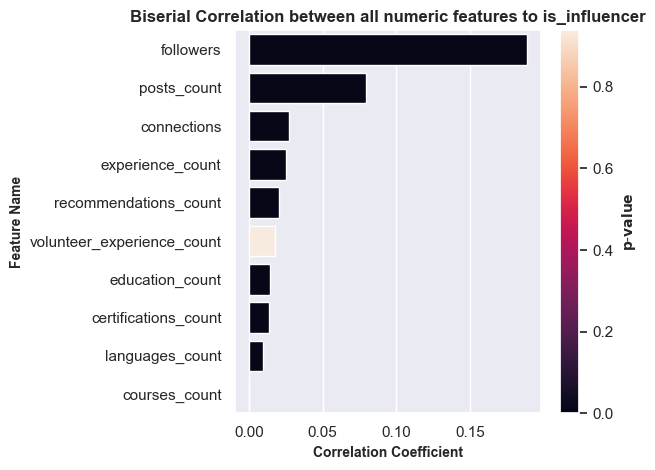

In [117]:
# Feature Imprortance 
corr_values = {}
p_values = {}

numeric_columns = ['followers', 'connections', 'recommendations_count', 'certifications_count', 'volunteer_experience_count','сourses_count', 'education_count', 'experience_count', 'posts_count', 'languages_count']
for col in numeric_columns:
    non_nan = df.dropna(subset=[col])

    corr, pval = pointbiserialr(non_nan[col].astype(float), non_nan["is_influencer"].astype(int)) # Correlation metric between numeric and binary columns (features and label) 
    corr_values[col] = corr
    p_values[col] = pval

# Sort the dictionaries by absolute correlation values
sorted_values = sorted(zip(corr_values.values(), p_values.values(), corr_values.keys()), key=lambda x: x[0], reverse=True)
corr_series = pd.Series([x[0] for x in sorted_values], index=[x[2] for x in sorted_values])
p_series = pd.Series([x[1] for x in sorted_values], index=[x[2] for x in sorted_values])

# Create color mapping based on p-values
vmax = max(p_values.values())
cmap = sns.cm.rocket
p_colors = [cmap(p/vmax) for p in p_values.values()]

# Create figure and axis objects
fig, ax = plt.subplots()

# Create bar plot of correlation values
sns.barplot(x=corr_series.values, 
            y=corr_series.index,
            palette=p_colors)

# Add legend for color mapping
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
sm.set_array([])
plt.colorbar(sm, label=r"$\mathbf{p\text{-}value}$", ax=ax)

# Set plot title and labels
ax.set_title("Biserial Correlation between all numeric features to is_influencer", fontweight = "bold")
ax.set_xlabel("Correlation Coefficient", fontweight = "bold")
ax.set_ylabel("Feature Name", fontweight = "bold")
plt.tight_layout()
plt.show()

#### Features Distribution Analysis 

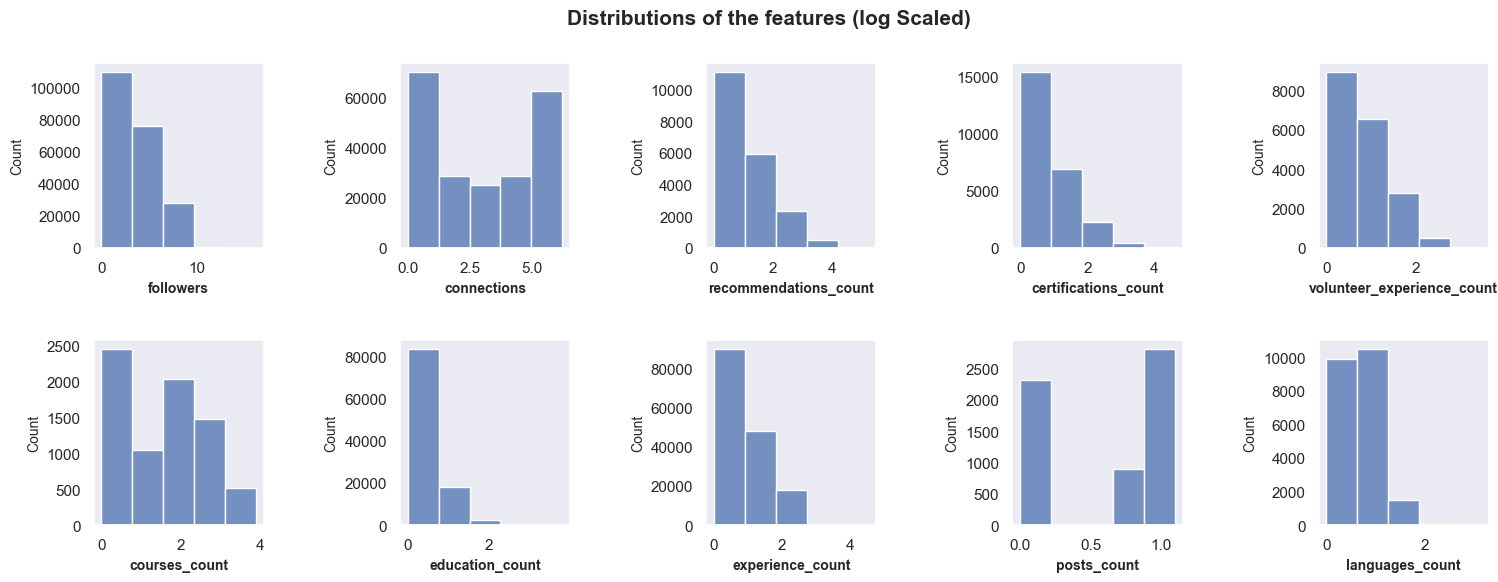

In [118]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 6))
plt.subplots_adjust(wspace=0.8, hspace=0.5)
fig.suptitle("Distributions of the features (log Scaled)", fontsize=15, fontweight="bold", y=0.97)
i = 0
for col in numeric_columns:
    data = np.log(df[df[col] > 0][col])
    sns.histplot(data, ax=axes[i//5, i%5], bins=5)
    axes[i//5, i%5].set_xlabel(col, fontweight="bold")
    axes[i//5, i%5].grid(False)
    i += 1
plt.show()

#### Features with small correlation to the label

In [146]:
pd.DataFrame(df[df['is_influencer'] == 1]['current_company:name'].value_counts().sort_values().head(5))

,current_company:name
Astrolab,1
SE Factory,1
Smart Venture Podcast,1
Microsoft,1
ThreeSixtyEight,1


In [147]:
pd.DataFrame(df[df['is_influencer'] == 1]['city'].value_counts().sort_values().head(5))

,city
"Seattle, Washington, United States",1
"Baton Rouge, Louisiana, United States",1
"Madison, Wisconsin, United States",1
"Oakdale, Tennessee, United States",1
"Menlo Park, California, United States",1


In [234]:
# Extracting the important features
important_columns = ["followers",  "posts", "connections", "experience", "recommendations", "about", "position", "volunteer_experience", "education", "certifications", "languages", "сourses"]

#### Undersampling- Reduce the negative samples while maintain the original features distribution

In [183]:
def count_null_values(values):
    return sum(value in null_values for value in values)

df['important_columns_null_count'] = df[important_columns].apply(count_null_values, axis=1)
df['important_columns_null_count'].value_counts().sort_index()

0      176
1     1427
2     4373
3     9735
4    18207
5    29955
6    40738
7    61678
8    44105
9     5038
Name: important_columns_null_count, dtype: int64

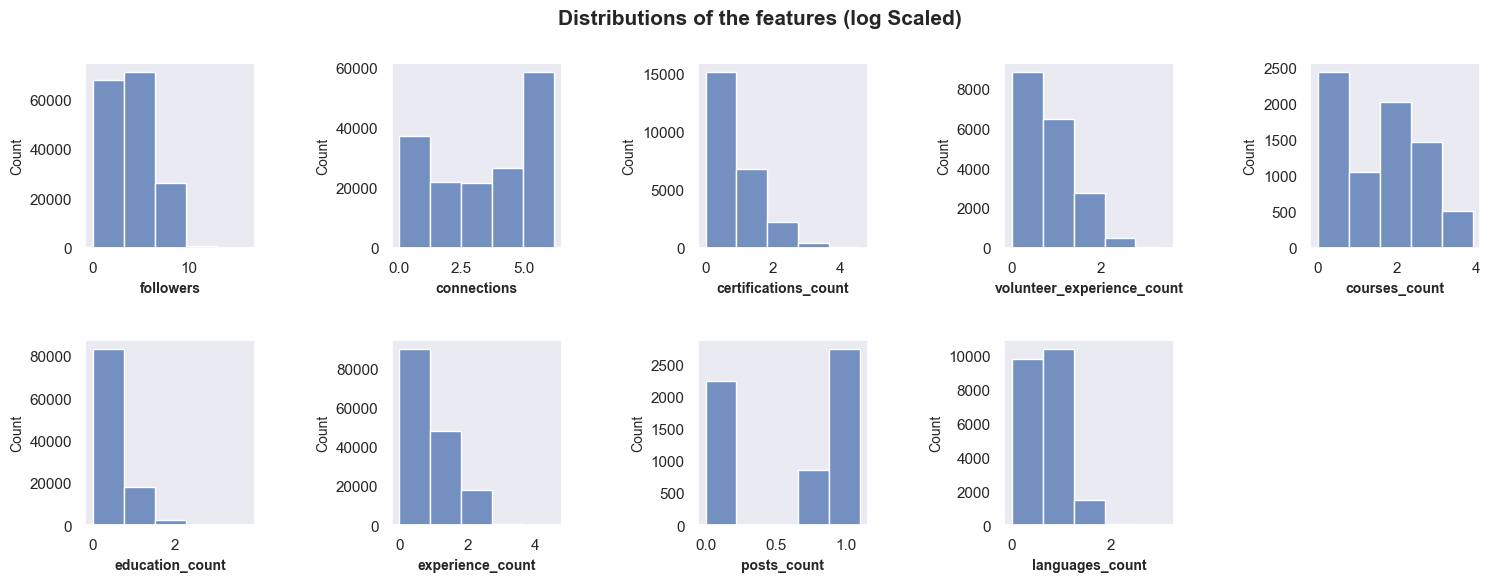

In [185]:
df_max_7_null = df[df['important_columns_null_count'] <= 7]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 6))
plt.subplots_adjust(wspace=0.8, hspace=0.5)
fig.suptitle("Distributions of the features (log Scaled)", fontsize=15, fontweight="bold", y=0.97)
i = 0
for col in numeric_columns:
    if col != 'recommendations_count':
        data = np.log(df_max_7_null[df_max_7_null[col] > 0][col])
        sns.histplot(data, ax=axes[i//5, i%5], bins=5)
        axes[i//5, i%5].set_xlabel(col, fontweight="bold")
        axes[i//5, i%5].grid(False)
        i += 1

fig.delaxes(axes[1,4])
plt.show()

In [235]:
df_sampled = df_max_7_null.sample(n=700, random_state=42)

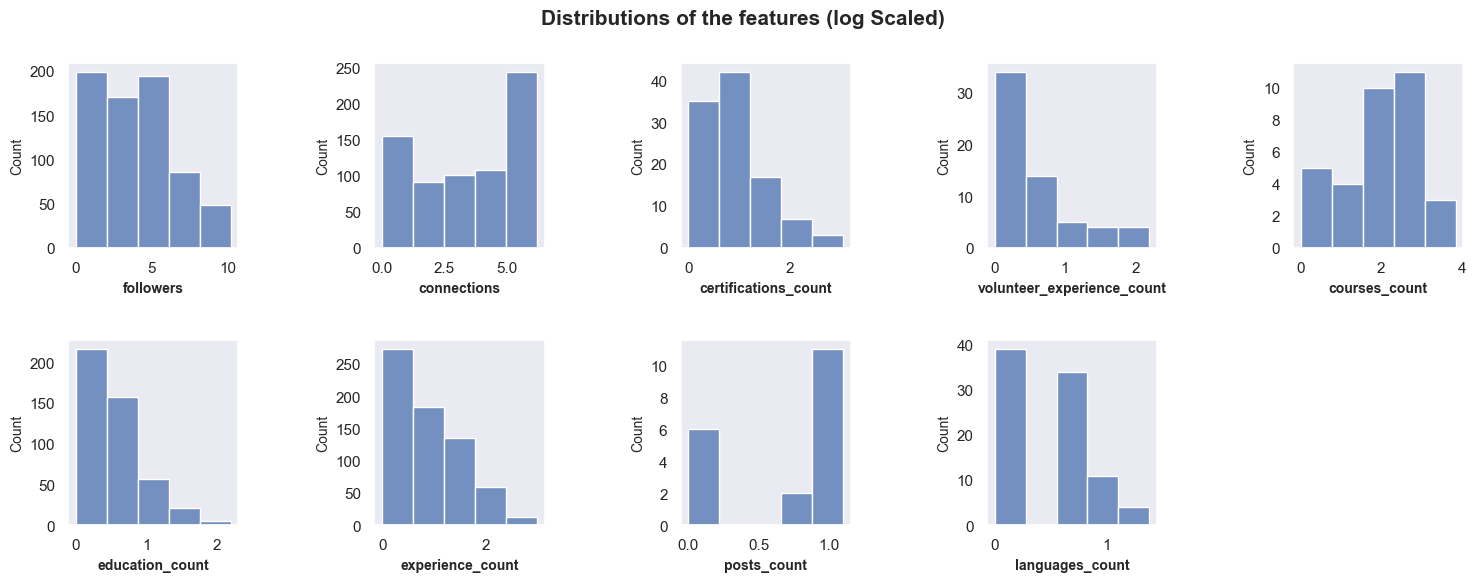

In [188]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 6))
plt.subplots_adjust(wspace=0.8, hspace=0.5)
fig.suptitle("Distributions of the features (log Scaled)", fontsize=15, fontweight="bold", y=0.97)
i = 0
for col in numeric_columns:
    if col != 'recommendations_count':
        data = np.log(df_sampled[df_sampled[col] > 0][col])
        sns.histplot(data, ax=axes[i//5, i%5], bins=5)
        axes[i//5, i%5].set_xlabel(col, fontweight="bold")
        axes[i//5, i%5].grid(False)
        i += 1

fig.delaxes(axes[1,4])
plt.show()

In [189]:
# null distriubtion after undersampling 
df_sampled['important_columns_null_count'].value_counts().sort_index()

1      5
2     12
3     39
4     88
5    133
6    184
7    239
Name: important_columns_null_count, dtype: int64

In [197]:
# Final under-sampled df: 
influencers_df = df[df['is_influencer'] == 1] # all positive examples
concated_df = pd.concat([df_sampled, influencers_df]) # concate sampled negative examples and all positive
concated_df = concated_df.sample(frac=1, random_state=42).reset_index(drop=True)
concated_df.to_pickle('data/undersampled_df.pickle')

#### Feature Importance 

In [224]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split

df_pos = concated_df[concated_df['is_influencer'] == 1]
df_neg = concated_df[concated_df['is_influencer'] == 0]
train_pos, test_pos = train_test_split(df_pos, test_size=0.2)
neg_1, neg_2 = train_test_split(df_neg, test_size=0.2)
train_df = pd.concat([train_pos, neg_1])

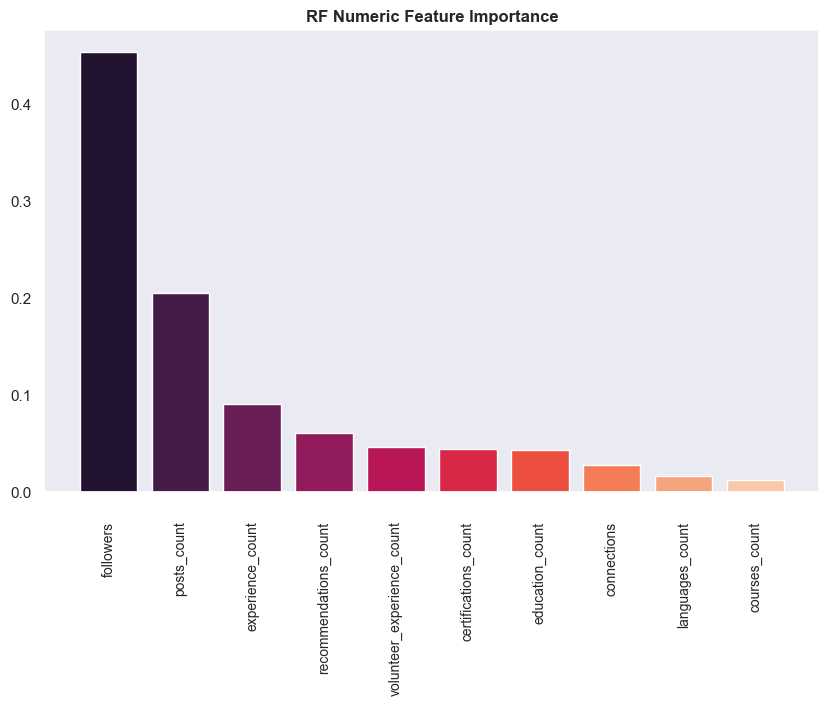

In [225]:
X_train, y_train = train_df[numeric_columns], train_df['is_influencer']
model = RandomForestClassifier()
model.fit(X_train, y_train)

importances_df = pd.DataFrame({"feature_names" : model.feature_names_in_, "importances" : model.feature_importances_}).sort_values(by='importances', ascending=False)
colors = sns.color_palette("rocket", len(model.feature_names_in_))

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(importances_df["feature_names"], importances_df["importances"], color = colors)
ax.set_xticks(range(len(importances_df["feature_names"])))
ax.set_xticklabels(importances_df["feature_names"], rotation=90, ha='center', fontsize=10)
ax.tick_params(axis='x', which='major', pad=15)
ax.set_title("RF Numeric Feature Importance", fontweight = "bold")
plt.grid(False)
plt.show()